### **Importing Libraries**

In [16]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import wandb
from skimage.feature import hog
from skimage import exposure
import seaborn as sns
import copy
from IPython.display import Image
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torchvision.models as models
import tqdm
from torchvision import transforms
import pandas as pd
from scipy import stats

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### **2.1**

#### **Loading Dataset**

In [2]:
data = pd.read_csv('data.csv')
data.head(1)

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43


#### **Handling Missing Values**

In [3]:
missing_data = data.apply(pd.isna).sum()
print("Missing data per column:\n", missing_data)

numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

categorical_columns = data.select_dtypes(include=[object]).columns
for col in categorical_columns:
    data[col] = data[col].fillna(data[col].mode().iloc[0])

remaining_missing = data.apply(pd.isna).sum()
print("\nRemaining missing values:\n", remaining_missing)

Missing data per column:
 Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

Remaining missing values:
 Order_ID                  0
Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64


#### **Plotting**

/home/chetan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chetan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chetan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chetan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

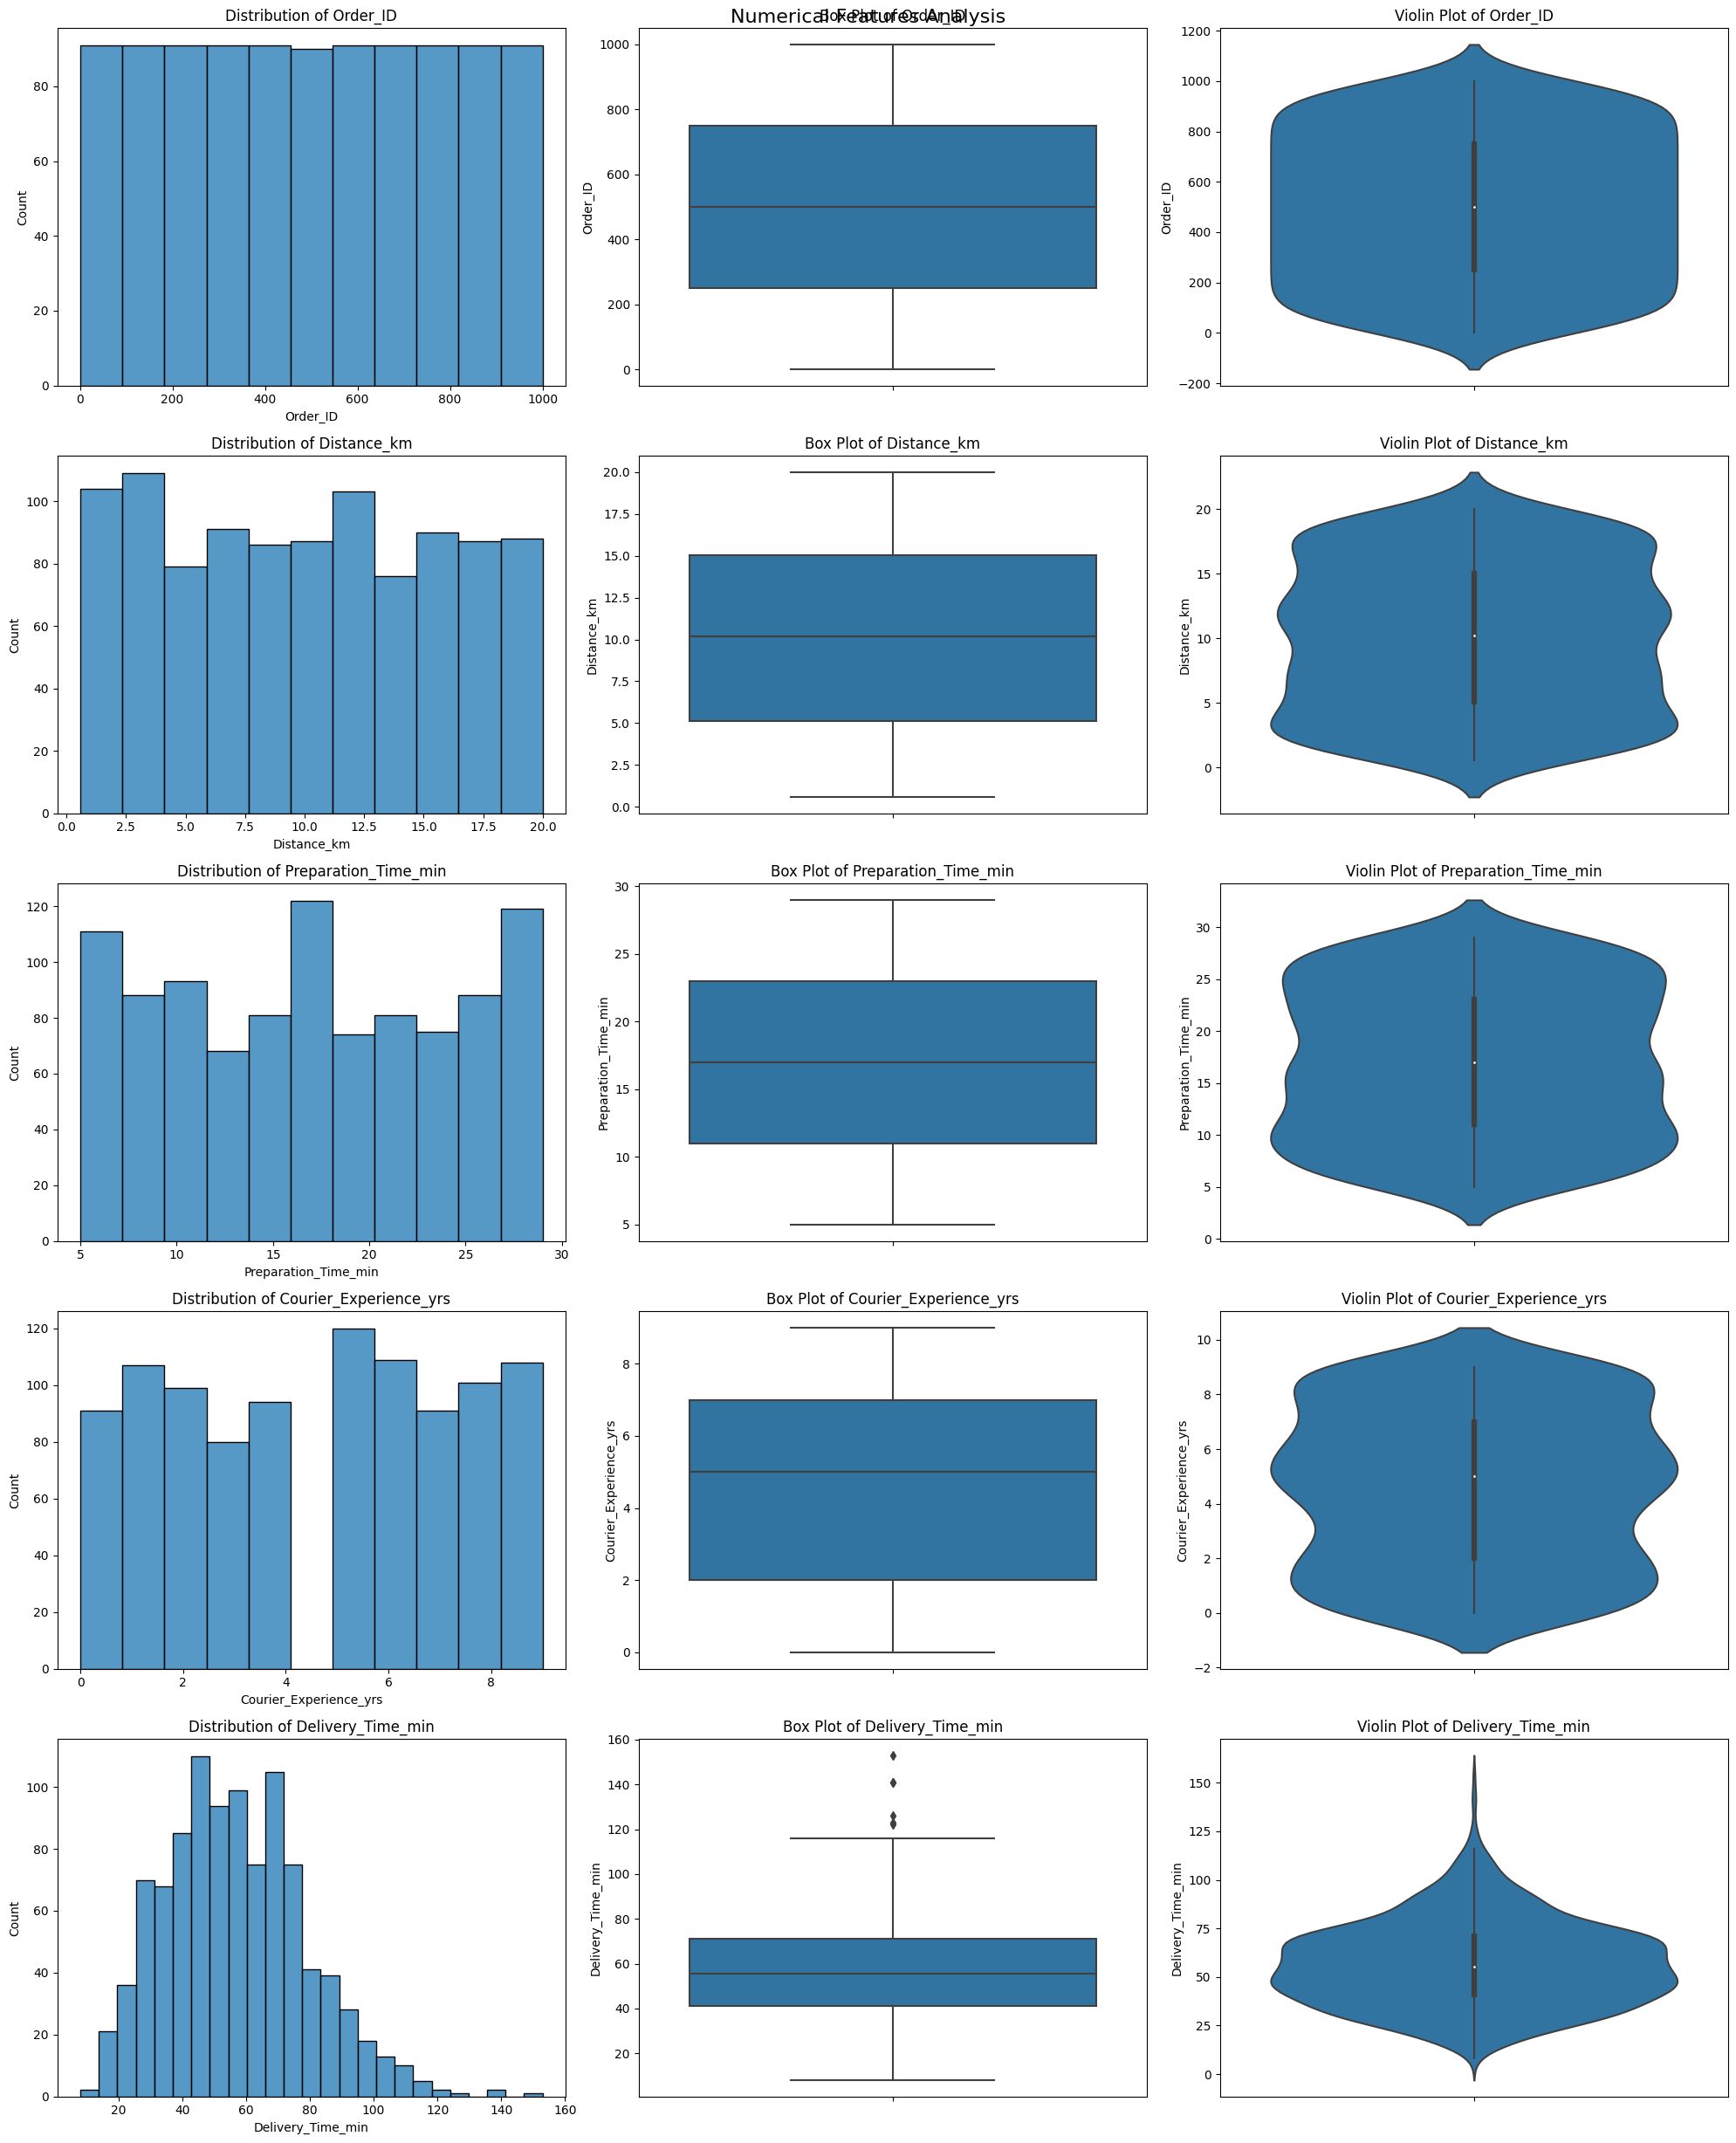

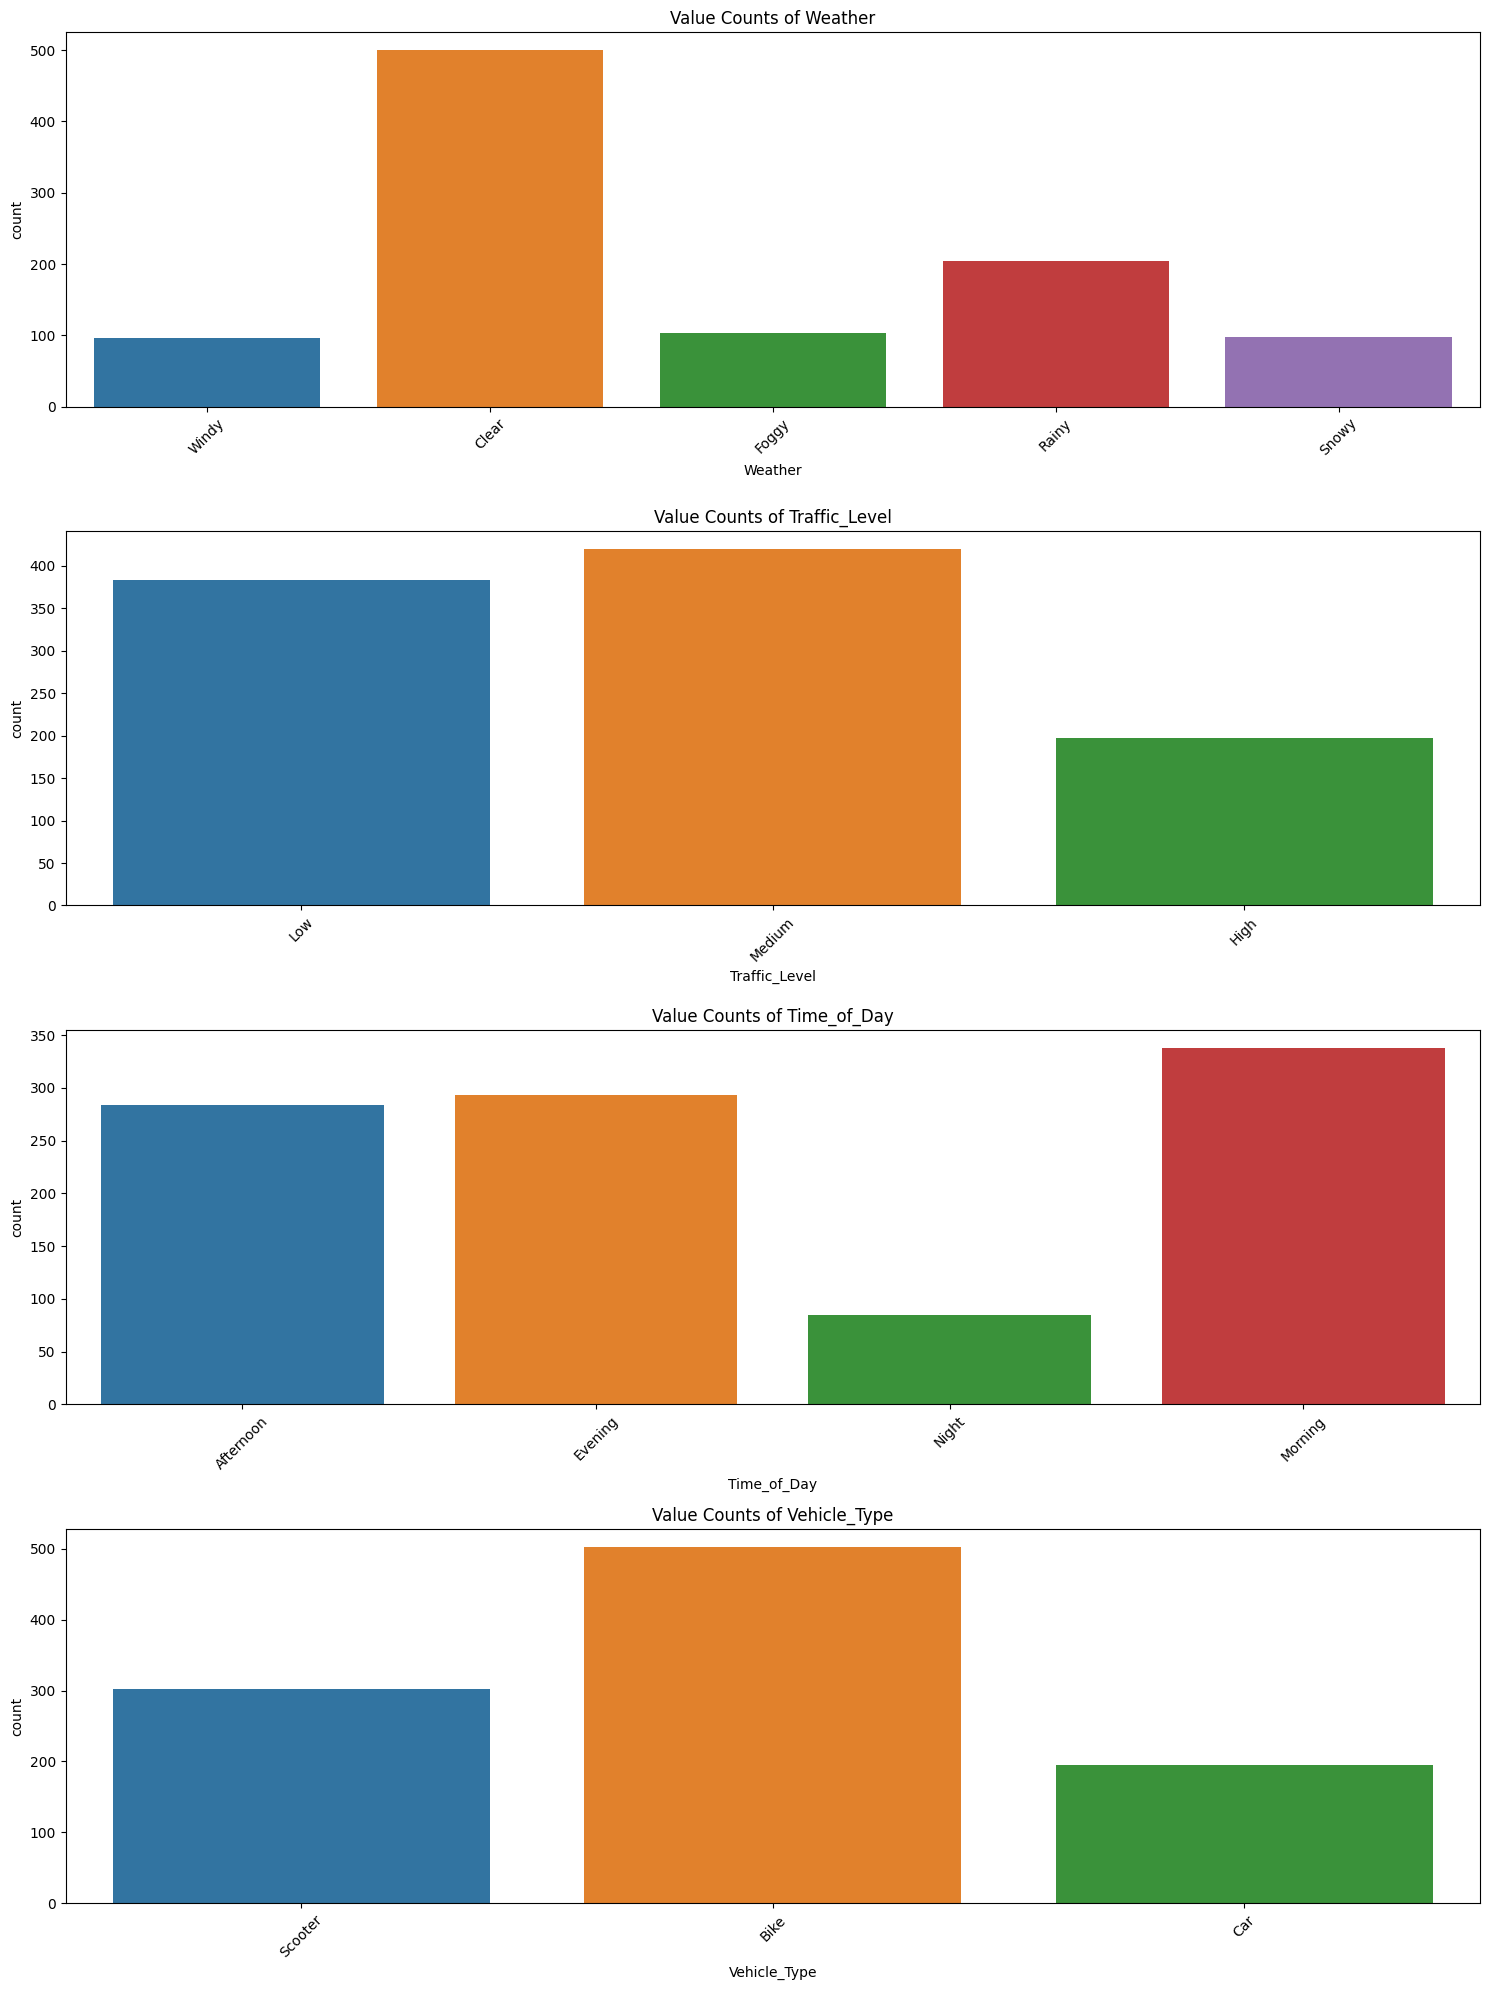


Numerical Features Summary:
          Order_ID  Distance_km  Preparation_Time_min  Courier_Experience_yrs  \
count  1000.000000  1000.000000           1000.000000             1000.000000   
mean    500.500000    10.059970             16.982000                4.592000   
std     288.819436     5.696656              7.204553                2.871198   
min       1.000000     0.590000              5.000000                0.000000   
25%     250.750000     5.105000             11.000000                2.000000   
50%     500.500000    10.190000             17.000000                5.000000   
75%     750.250000    15.017500             23.000000                7.000000   
max    1000.000000    19.990000             29.000000                9.000000   

       Delivery_Time_min  
count        1000.000000  
mean           56.732000  
std            22.070915  
min             8.000000  
25%            41.000000  
50%            55.500000  
75%            71.000000  
max           153.000000 

In [11]:
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

fig, axes = plt.subplots(len(numeric_cols), 3, figsize=(20, 5*len(numeric_cols)))
fig.suptitle('Numerical Features Analysis', fontsize=16)

for idx, col in enumerate(numeric_cols):

    sns.histplot(data=data, x=col, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'Distribution of {col}')
    
    sns.boxplot(data=data, y=col, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'Box Plot of {col}')
    
    sns.violinplot(data=data, y=col, ax=axes[idx, 2])
    axes[idx, 2].set_title(f'Violin Plot of {col}')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5*len(categorical_cols)))

for idx, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols), 1, idx)
    sns.countplot(data=data, x=col)
    plt.title(f'Value Counts of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


print("\nNumerical Features Summary:")
print(data[numeric_cols].describe())

print("\nCategorical Features Summary:")
for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    print(data[col].value_counts())


#### **Splitting Data**

In [18]:
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

train_transformed = preprocessor.fit_transform(train_data)
val_transformed = preprocessor.transform(val_data)
test_transformed = preprocessor.transform(test_data)

train_transformed_df = pd.DataFrame(train_transformed)
val_transformed_df = pd.DataFrame(val_transformed)
test_transformed_df = pd.DataFrame(test_transformed)

print(f"Number of datapoints in training set: {train_transformed_df.shape[0]}")
print(f"Number of datapoints in validation set: {val_transformed_df.shape[0]}")
print(f"Number of datapoints in test set: {test_transformed_df.shape[0]}")

Number of datapoints in training set: 700
Number of datapoints in validation set: 150
Number of datapoints in test set: 150
